# AVM Tutorial  - Tyler Hughes (Stanford University)

Adjoint variable method (or AVM) is a method for computing the derivative of an objective function with respect to several degrees of freedom in the system.  

For a dielectric laser accelerator, for instance, one could imagine these degrees of freedom being the height or width of the grating or radius of a pillar.  

With this gradient information, one can optimize structures easily by doing a gradient-based optimization procedure, such as gradient ascent, where the structure is repeatedly updated based on gradient information.

The main advantage of AVM is that no matter how many degrees of freedom you have, you can compute the gradient with respect to **all** of them using only 2 electromagnetic simulations:

1.  The first we will call the 'original', which corresponds to the sitation that you want to optimize.  
2.  The second we will call the 'adjoint',  which contains information about the objective function that we care about maximizing or minimizing.

Because of the ability to compute derivatives with respect to several degrees of freedom with little additional computational cost, one option is to take the dielectric function or permittivity at each point in space as our degrees of freedom.  This was done in [this work](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-25-13-15414), which I will be briefly summarizing in this talk.

## Live Demo

For us, the starting point for AVM will be the finite-difference frequency-domain algorithm (or FDFD), which solves for the electromagnetic fields in steady state (frequency domain).  For more details, [this](http://www.mit.edu/~wsshin/pdf/shin_dissertation_updated.pdf) is a good reference.

Before explaining FDFD in detail, we will load the modules we will need to use to run it, including:

* ```numpy``` (python's numerical math package)
* ```matplotlib``` (for plotting)
* ```python_fdfd``` (our FDFD package)

The first two will need to be installed, but the third is included in this directory.  

We'll also be using ```progressbar2``` for convenience.

To install everything with ```pip``` via the command line, use ```pip install -r requirements.txt```.

We will be using an FDFD written in python by [Ian Williamson](https://github.com/ianwilliamson) from my group, although MATLAB versions can also be found at [my github](https://github.com/twhughes) or supplied upon request.

Finally, the full code for this tutorial is available [here](https://github.com/twhughes/AVM_Workshop).

Let's get started..

In [1]:
# Some python notebook magic to automatically reload src files
%load_ext autoreload
%autoreload 2

# import the modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from python_fdfd.fdfd import assign_val, driven
import progressbar

%matplotlib inline
# I'm using my own stylesheet for plotting.  (Comment out if not connected to internet)
plt.style.use(['https://git.io/photons.mplstyle',
               'https://git.io/photons-presentation.mplstyle'])

We will start with just a simple FDFD simulation to understand the basics before moving to AVM.  
The domain we want to create is diagrammed in the image below.  

* On the outside, we have PMLs (perfectly matched layers), which act as an absorbing layer around our simulation, simulating an infinite space.
* A dielectric rectangle sits in the center of the domain.
* A point source is placed left of the dielectric rectangle.

<img src="./img/Scene.png" width="500" />

Now we will define some of our important variables for running the simulation.


In [2]:
# number of x,y grid points in domain
N = (100, 100)

# spatial ranges for the domain (m)
xrange = (-2e-6, 2e-6)
yrange = (-2e-6, 2e-6)

# angular frequency of source (rad/s)
omega = 2*np.pi*200e12

# define the relative permittivity of the region (adding rectangle)
eps_r = np.ones(N, dtype=complex)
rel_permittivity = 3
within_rect1 = lambda x, y: np.logical_and.reduce((-0.5e-6<x,x<0.5e-6,-0.75e-6<y,y<0.75e-6))
eps_r = assign_val(eps_r, within_rect1, rel_permittivity, xrange, yrange)

# define the point source
Jz = np.zeros(N, dtype=complex)
Jz[N[0]//4,N[1]//2] = 1

# define number of PMLs (should have about as many PMLs points as grids in a wavelength, 10 is usually ok)
Npml = (10, 10)


Now that our source and domain are defined, we may use FDFD to solve for the electromagnetic fields.

Assuming an anisotripic, reciprocal, and non-magnetic system (most normal cases) FDFD solves for the fields at a given frequency $\omega$ by solving the equation

$$ \frac{1}{\mu_0}\nabla \times \nabla \times E(r) - \omega^2\epsilon_0  \epsilon_r(r) E(r) = i\omega J(r)$$

for the electric fields $E(r)$.  This equation is derived straightforwardly from the steady state (single $\omega$) Maxwell's equations.

FDFD does this by representing the electric fields, permittivity distributions, and source on a [Yee lattice](https://meep.readthedocs.io/en/latest/Yee_Lattice/) and then expressing the $\nabla \times \nabla \times$ operator as finite difference derivative matrix, $\hat{D}$.

In the discrete case, we may write our original equation as a big matrix equation:

$$ \left[\hat{D} - \omega^2\epsilon_0 \hat{\epsilon}_r \right] \mathbf{E} = i\omega \mathbf{J}$$
$$ \equiv \hat{A}\mathbf{E} = \mathbf{b}$$

Let's break down the terms here:
* $\hat{D}$ is a real-valued matrix that performs the finite difference derivative $\frac{1}{\mu_0}\nabla \times \nabla \times$.  It does not depend on our permittivity distribution.
* $\hat{\epsilon}_r$ is a **diagonal** complex-valued matrix.  Each element along the diagonal corresponds to the relative permittivity of one cell in our domain.  Although the underlying relative permittivity may be real-valued, it becomes complex when PMLs are added as the system now has loss.
* $\mathbf{E}$ is a complex vector representing the (unknown) electric field distribution in the domain.
* $\mathbf{b}$ is a complex vector representing the driving current source distribution.

**NOTE 1:** $\hat{\epsilon}_r$, $\mathbf{E}$, and $\mathbf{b}$ are **flattened** representations of the original objects in 2D or 3D.  They must therefore each be flattened according to the same procedure, such as   `E_vec = E(:)`   in matlab.

**NOTE 2:** If we have $M$ x $N$ grids in our simulation, the matrix $\hat{A}$ is of dimension ($MN$) x ($MN$).  If M and N are small (lets say 100), then we still will have a matrix $\hat{A}$ with 10,000 x 10,000 = 100,000,000 elements, which is getting quite large! (especially for the next step..)  Therefore, we need to make sure that we construct $\hat{A}$ as a **sparse** matrix

Now that we understand how to set up our simulation, we must solve for the fields.  

This can be written simply as:

$$ \mathbf{E} = \hat{A}^{-1}\mathbf{b}$$

Thankfully this can be done very simply through a direct, sparse linear solver:
* MATLAB:  `E = A\b`
* Python:  `E = scipy.sparse.linalg.spsolve(A,b)`

These numerical packages will take care of the work for you.  **DO NOT** solve for $A^{-1}$ directly, for instance by doing `E = inv(A)*b` as this is highly inefficient.  

Also, Since these built-in solvers perform LU decomposition on A, instead of storing `inv(A)`, you may save this factorization for later solves with different sources if you desire.

For 3D simulations, one will generally have to use an iterative solver instead.

Now we are finally ready to do the field solution:

With this fdfd package, we simply call a function with our variables and it will do all of this behind the scenes and return the fields.


In [3]:
# solve for the fields in our domain with FDFD
(Ez,Hx,Hy) = driven.solve_TM(omega, xrange, yrange, eps_r, Jz, Npml)

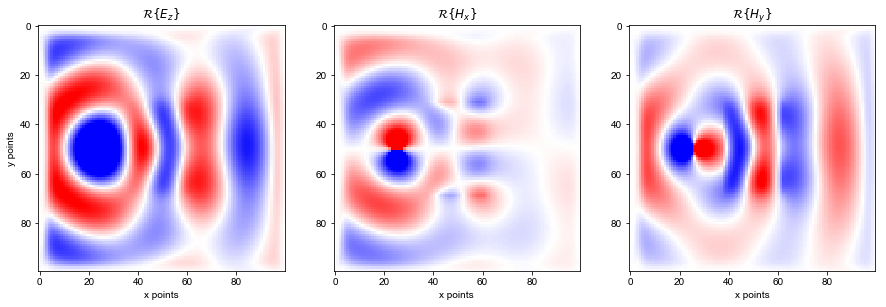

In [4]:
# plot the field components
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
Ezplt = ax1.imshow(np.real(Ez[0]).T, cmap = "bwr", vmin = -3e-7, vmax = 3e-7)
Hxplt = ax2.imshow(np.real(Hx[0]).T, cmap = "bwr", vmin = -1e-9, vmax = 1e-9)
Hyplt = ax3.imshow(np.real(Hy[0]).T, cmap = "bwr", vmin = -1e-9, vmax = 1e-9)
ax1.set_title('$\mathcal{R}\{ E_z \}$')
ax2.set_title('$\mathcal{R}\{ H_x \}$')
ax3.set_title('$\mathcal{R}\{ H_y \}$')
ax1.set_xlabel('x points')
ax2.set_xlabel('x points')
ax3.set_xlabel('x points')
ax1.set_ylabel('y points')
plt.show()

## AVM

To summarize, with FDFD, we first construct our $\hat{A}$ matrix

$$ \hat{A} = \frac{1}{\mu_0}\nabla \times \nabla \times - \omega^2\epsilon_0 \epsilon_r(r) $$

and our source vector

$$ \mathbf{b} = i\omega J(r)$$

and then we solve for the electric fields using a linear solve:

$$ \mathbf{E} = \hat{A}^{-1}\mathbf{b}$$

However, in many optimization problems, we would like to evaluate an 'objective function' that depends on the electric field distribution, we will call this $J(\mathbf{E})$ for now.

If we are doing optimization, we would like $J$ to be a real-valued scalar quantity that we can either minimize or maximize with respect to the degrees of freedom in our system.

For sake of argument, lets say we would like to minimize $J$ with respect to the relative permittivity at position $r'$ in our system.  

What we would like to do is to compute the derivative of $J$ with respect to $\epsilon_r(r')$.  Let's write this out:

$$ \frac{dJ}{d\epsilon_r(r')}  = \frac{\partial J}{\partial \mathbf{E}}\frac{d \mathbf{E}}{d\epsilon_r(r')} + \frac{\partial J}{\partial \mathbf{E}*}\frac{d \mathbf{E}*}{d\epsilon_r(r')} $$

where we have assumed $J$ does not depend explicitly on the permittivity distribution.

Because we assume both $J$ and $\epsilon_r(r')$ are real, this becomes:

$$ \frac{dJ}{d\epsilon_r(r')}  = \mathcal{R}\left\{ 2 \frac{\partial J}{\partial \mathbf{E}} \frac{d \mathbf{E}}{d\epsilon_r(r')} \right\} $$

As a sanity check, $\frac{\partial J}{\partial \mathbf{E}}$ is a row vector, which only depends on the choice of objective function and $\frac{d \mathbf{E}}{d\epsilon_r(r')}$ is a vector that we will evaluate by examining our FDFD simulation.  Therefore, our $\frac{dJ}{d\epsilon_r(r')}$ quantity is a real-valued scalar, as desired.

To evaluate $\frac{d \mathbf{E}}{d\epsilon_r(r')}$, we do a bit of calculus

$$ \frac{d \mathbf{E}}{d\epsilon_r(r')} = \frac{d \left(\hat{A}^{-1}\mathbf{b}\right)}{d\epsilon_r(r')}$$

$$ = -\hat{A}^{-1} \frac{d \hat{A}}{d\epsilon_r(r')} \hat{A}^{-1}\mathbf{b}$$
where we have used the fact that $\mathbf{b}$ does not depend on $\epsilon_r$

Noticing that $\hat{A}^{-1}\mathbf{b} = \mathbf{E}$ and resubstituting, we arrive at:

$$ \frac{d \mathbf{E}}{d\epsilon_r(r')} = -\hat{A}^{-1} \frac{d \hat{A}}{d\epsilon_r(r')} \mathbf{E}$$

Finally, in our original equation now, we have:

$$ \frac{dJ}{d\epsilon_r(r')}  = \mathcal{R}\left\{ -2 \frac{\partial J}{\partial \mathbf{E}} \hat{A}^{-1} \frac{d \hat{A}}{d\epsilon_r(r')} \mathbf{E} \right\} $$

Because of reciprocity, we are guarenteed that $\hat{A}^T = \hat{A}$ and $\hat{A}^{-T} = \hat{A}^{-1}$.  Thus, we can group the terms on the left of this equation.

$$\mathbf{E}_{aj}^T \equiv -2 \frac{\partial J}{\partial \mathbf{E}} \hat{A}^{-1}$$

or, to write in a different way (taking transpose)

$$\mathbf{E}_{aj} \equiv \hat{A}^{-1} \left( -2 \frac{\partial J}{\partial \mathbf{E}}^T  \right)$$

We then notice that $ \mathbf{E}_{aj}$ is the field solution that we get from solving

$$\hat{A} \mathbf{E}_{aj} = -2 \frac{\partial J}{\partial \mathbf{E}}^T$$

Which is a simulation with the same system ($\hat{A}$) but now instead of a source $\mathbf{b}$, the source is $-2 \frac{\partial J}{\partial \mathbf{E}}^T$, which depends on our objective function.  This field solution is what is called the **adjoint** field and the equation above for solving for it is the **adjoint** problem.

Thus, we can write the change in objective function with respect to the permittivity at point $r'$ as the overlap between two electric fields $\mathbf{E}$ and $\mathbf{E}_{aj}$:

$$ \frac{dJ}{d\epsilon_r(r')}  = \mathcal{R}\left\{ \mathbf{E}_{aj}^T \frac{d \hat{A}}{d\epsilon_r(r')} \mathbf{E} \right\} $$

The matrix $\frac{d \hat{A}}{d\epsilon_r(r')}$ can be evaluated simply by inspecting the form of $\hat{A}$, since $\hat{A}$ contains a matrix with $\epsilon_r(r)$ along the diagonal, when we differentiate this matrix with respect to $\epsilon_r(r')$ it will give a matrix where there is $-\omega^2\epsilon_0$ along the diagonal where $r' = r$ and 0 everywhere else. 

We can call this matrix $-\omega^2\epsilon_0\hat{\delta}_{r,r'}$ where it is like a kronecker delta.

Inserting this, we get some nice simplification of the expression for the derivative, which now only depends on the orginal and the adjoint fields as.

$$ \frac{dJ}{d\epsilon_r(r')}  = -\omega^2\epsilon_0\mathcal{R}\left\{ \mathbf{E}_{aj}^T \hat{\delta}_{r,r'} \mathbf{E} \right\} = -\omega^2\epsilon_0\mathcal{R}\left\{ \mathbf{E}(r') \mathbf{E}_{aj}(r') \right\} $$

The real power of this expression is that if we want to now look at the change in our objective function with respect to the permittivity at any general point, $r$, we can reuse our field solutions 

$$ \frac{dJ}{d\epsilon_r(r)}  =  -\omega^2\epsilon_0\mathcal{R}\left\{ \mathbf{E}(r) \mathbf{E}_{aj}(r) \right\} $$

In this way, we are able to get the change in objective function with respect to **each** pixel in our permittivity distribution **at once** all by doing two field simulations and using the equation above.  Even if we have tons of pixels, once we solve for $\mathbf{E}_{aj}$, we have our derivatives.


## Example

To see how this works, let's look at a very simple example.

Let's say that we're interested in the same situation as before (point source next to a dielectric rectangle) but now we want to maximize the electric field intensity at a point on the other side of the rectangle.

<img src="./img/Objective.png" width="500" />


To simplify the problem, we may write down a vector $\boldsymbol{\eta}$ that gives 1 at that target position and 0 elsewhere.

Now, we can express an objective function as 

$$J(\mathbf{E}) = \left|\boldsymbol{\eta}^T \mathbf{E}\right|^2 = \left(\boldsymbol{\eta}^T \mathbf{E} \right)^*\left(\boldsymbol{\eta}^T \mathbf{E}\right)$$

To construct our adjoint source, one can show

$$\hat{A} \mathbf{E}_{aj} = -2 \frac{\partial J}{\partial \mathbf{E}}^T = -2 \left(\boldsymbol{\eta}^T \mathbf{E} \right)^* \boldsymbol{\eta}$$

Therefore, the source for our adjoint field is at the probe location, $\boldsymbol{\eta}$, and has a (complex-valued) amplitude that is -2 times the complex conjugate of the forward field evaluated at the proble location.

We can easily code this up with our FDFD solver:

In [5]:
eta = np.zeros(N)
eta[3*N[0]//4,N[1]//2] = 1
Jz_aj = -2*np.conj(Ez*eta)*eta/1j/omega

(Ez_aj,Hx_aj,Hy_aj) = driven.solve_TM(omega, xrange, yrange, eps_r, Jz_aj, Npml)

Lets plot the adjoint fields

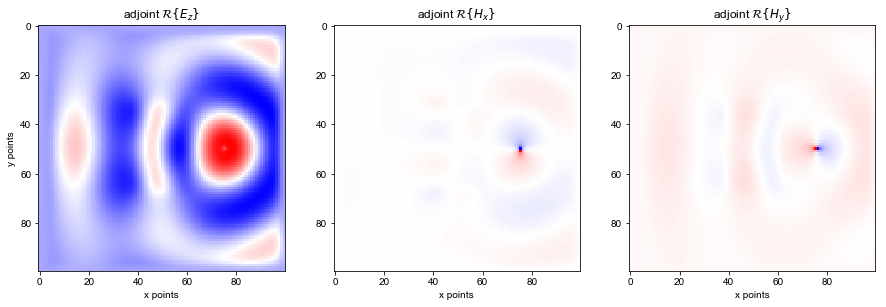

In [6]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
Ezplt = ax1.imshow(np.real(Ez_aj[0]).T, cmap = "bwr")#, vmin = -2e-11, vmax = 2e-11)
Hxplt = ax2.imshow(np.real(Hx_aj[0]).T, cmap = "bwr")#, vmin = -5e-14, vmax = 5e-14)
Hyplt = ax3.imshow(np.real(Hy_aj[0]).T, cmap = "bwr")#, vmin = -5e-14, vmax = 5e-14)
ax1.set_title('adjoint $\mathcal{R}\{ E_z \}$')
ax2.set_title('adjoint $\mathcal{R}\{ H_x \}$')
ax3.set_title('adjoint $\mathcal{R}\{ H_y \}$')
ax1.set_xlabel('x points')
ax2.set_xlabel('x points')
ax3.set_xlabel('x points')
ax1.set_ylabel('y points')
plt.show()

Note that the adjoint is sourced at the right of the dielectric square, where we are measuring the intensity for our objective function.

And now, the sensitivity map can be plotted.

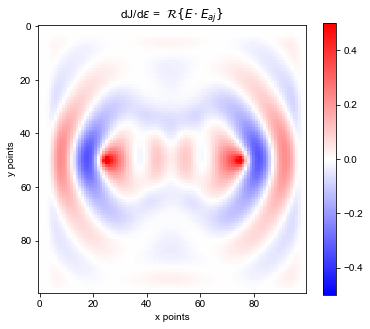

In [7]:
#plot the sensitivity map
f = plt.figure(figsize=(6,5))
max_abs = np.max(np.max(np.abs(Ez_aj[0]*Ez[0])))
Ezplt = plt.imshow(np.real(Ez_aj[0]*Ez[0]/max_abs).T, cmap = "bwr", vmin = -1/2, vmax = 1/2)
plt.title('dJ/d$\epsilon$ =  $\mathcal{R}\{ E \cdot E_{aj} \}$')
plt.xlabel('x points')
plt.ylabel('y points')
plt.colorbar()
plt.show()

This shows us how the objective function ($J$) will change when we change the relative permittivity of each point in the domain.

## Frequency Sweep

Your adjoint sensitivity should be consistent with that found by taking a numerical derivative, where the permittivity is manually changed by some small amount and the change in objective function is measured.

$$ \frac{dJ}{d\epsilon_r(r)}^{(num.)} = \frac{J(\epsilon_r(r)+\Delta) - J(\epsilon_r(r)-\Delta)}{2\Delta}$$

To do this, we'll compare AVM with numerical derivative when we scan the frequency.  For example, let's take our degree of fredom to be the permittivity of the entire box.

In this case, our total objective function can be evaluated by just summing over $\mathbf{E}$ and $\mathbf{E}_{aj}$ over the box location.

$$ \frac{dJ}{d\epsilon_{box}}  =  -k_0^2\sum_{r \in box}\mathcal{R}\left\{ \mathbf{E}(r) \mathbf{E}_{aj}(r) \right\} $$

This will take a minute or so

In [8]:
# frequency scan
Nf = 2           # number of frequencies to scan over
freqs = np.linspace(2*np.pi*150e12, 2*np.pi*250e12, Nf)
dJde_numerical = []
dJde_AVM = []

deps = 1e-6       # size of numerical permittivity update
er = 3            # relative permittivity
e0 = 8.854e-12

# loop through freqencies (use progress bar to track progress)
pgb = progressbar.ProgressBar(max_value=Nf)
for index, w in enumerate(freqs):
    pgb.update(index+1)
    
    # make source
    Jz = np.zeros(N, dtype=complex)
    Jz[N[0]//4,N[1]//2] = 1
    
    # numerical derivative    
    
    eps_up = np.ones(N, dtype=complex)    
    eps_up = assign_val(eps_up, within_rect1, er+deps/2, xrange, yrange)
    # compute fields and objective function when permittivity increased    
    (Ez_up,Hx,Hy) = driven.solve_TM(w, xrange, yrange, eps_up, Jz, Npml)
    J_up = np.abs(np.sum(np.sum(eta*Ez_up[0])))**2
    eps_down = np.ones(N, dtype=complex)        
    eps_down = assign_val(eps_down, within_rect1, er-deps/2, xrange, yrange)
    # compute fields and objective function when permittivity decreased    
    (Ez_down,Hx,Hy) = driven.solve_TM(w, xrange, yrange, eps_down, Jz, Npml)
    J_down = np.abs(np.sum(np.sum(eta*Ez_down[0])))**2
    # compute numerical derivative
    dJde_numerical.append((J_up - J_down)/deps)
    
    # adjoint derivative
    
    # compute original fields
    eps_r = np.ones(N, dtype=complex)        
    eps_r = assign_val(eps_r, within_rect1, er, xrange, yrange)  
    (Ez,Hx,Hy) = driven.solve_TM(w, xrange, yrange, eps_r, Jz, Npml)
    # construct adjoint soure (note the omega dependence..)
    Jz_aj = -2*np.conj(Ez[0]*eta)*eta/1j/w
    # solve adoint fields
    (Ez_aj,Hx_aj,Hy_aj) = driven.solve_TM(w, xrange, yrange, eps_r, Jz_aj, Npml)
    # compute adjoint derivative (summing field overlap over box region)
    dJde_AVM.append(w**2*e0*np.real(np.sum(np.sum((Ez[0]*Ez_aj[0]*(eps_r>1))))))
    

100% (2 of 2) |##########################| Elapsed Time: 0:00:01 ETA:  00:00:00

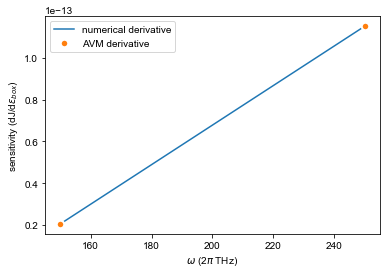

In [9]:
# Plot the results (should be perfect agreement)
num = plt.plot([f/1e12/2/np.pi for f in freqs],dJde_numerical)
avm = plt.plot([f/1e12/2/np.pi for f in freqs],dJde_AVM,'o')
plt.xlabel('$\omega$ (2$\pi$ THz)')
plt.ylabel('sensitivity (dJ/d$\epsilon_{box}$)')
plt.legend(['numerical derivative', 'AVM derivative'])
plt.show()

## Optimization / Inverse Design Demo

The power of this formalism is that it allows us to now optimize structures using each permittivity as our degree of freedom.

Let's take the same situation as before, but now design the central square region to maximize the intensity concentration at the target position.

We do this by first computing:

$$ \frac{dJ}{d\epsilon_r(r)} $$ for each $r$ in our design region using adjoints.

Then, we update the permittivity in that region by a simple gradient ascent update rule:

$$\epsilon_r(r) := \epsilon_r(r) + \alpha \frac{dJ}{d\epsilon_r(r)}$$

Where $\alpha$ is some small step size.

**NOTE**: the original and adjoint fields can be stored to compute the derivative with respect to the permittivity in each pixel.  One can do this either with a for loop, or (better) by just directly element-wise multiplying the fields together.

We continue this process until we have converged on a structure.

If $\epsilon_r(r)$ either gets smaller than 1 or larger than some cutoff during our iterations, we set them back inside the range.

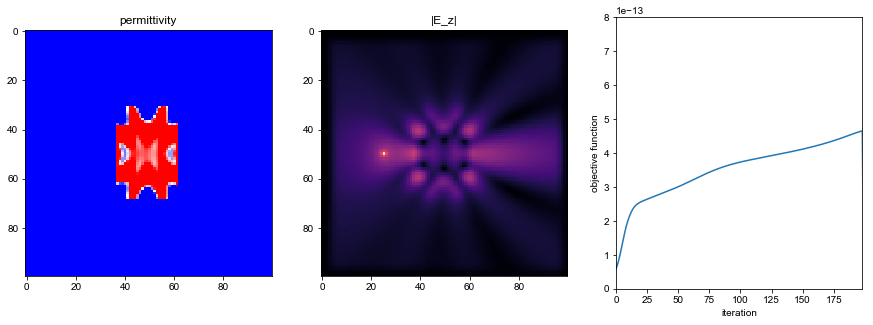

/anaconda3/envs/workshop/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


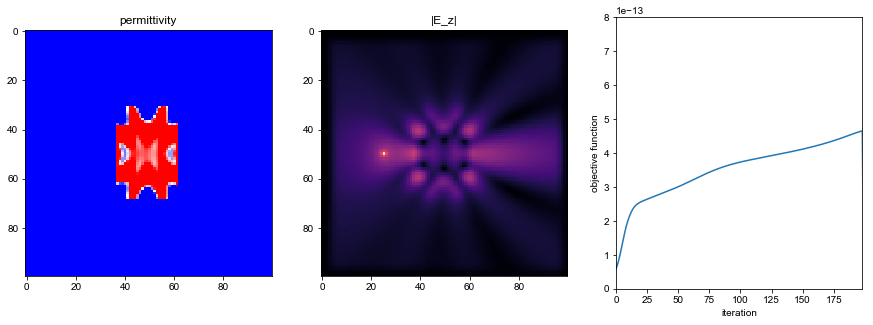

In [10]:
# inverse design demo: maximize intensity at probe location

N_iterations = 200
alpha = 1e14             # gradient ascent step size
eps_cutoff = 5           # maximum relative permittivity
eps_start = 3            # starting relative permittivity of box
omega = 2*np.pi*200e12

eps_r = np.ones(N, dtype=complex)        
eps_r = assign_val(eps_r, within_rect1, eps_start, xrange, yrange)

J_list = []

# Create a named display and plots to update in loop
handle = display(None, display_id=True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
perm_plot = ax1.imshow(np.real(eps_r.T), cmap="bwr")
field_plot = ax2.imshow(np.abs(Ez[0].T), cmap="magma")
J_line, = ax3.plot(range(N_iterations), [0 for _ in range(N_iterations)])
ax1.set_title('permittivity')
ax2.set_title('|E_z|')    
ax3.set_ylim([0,8e-13])
ax3.set_xlabel('iteration')
ax3.set_ylabel('objective function')

# run for several iterations
for iteration_counter in range(N_iterations):

    # solve for the original fields and objective function
    (Ez,Hx,Hy) = driven.solve_TM(w, xrange, yrange, eps_r, Jz, Npml)
    obj_fun = np.abs(np.sum(np.sum(eta*Ez[0])))**2
    J_list.append(obj_fun)
    
    # compute adjoint source and fields
    Jz_aj = -2*np.conj(Ez[0]*eta)*eta/1j/w
    (Ez_aj,Hx_aj,Hy_aj) = driven.solve_TM(w, xrange, yrange, eps_r, Jz_aj, Npml)
    
    # compute adjoint gradient with respect to ALL pixels in box region
    dJde_AVM = w**2*e0*np.real(Ez[0]*Ez_aj[0]*(eps_r>1))    
    
    # update permittivit with gradients, set outsiders back in range
    eps_r = eps_r + alpha*dJde_AVM
    eps_r[eps_r<1] = 1
    eps_r[eps_r>eps_cutoff] = eps_cutoff
    
    # update plots
    perm_plot.set_array(np.real(eps_r).T)
    field_plot.set_array(np.abs(Ez[0].T))
    J_line.set_ydata([J_list[i] for i in range(iteration_counter)] + [0 for i in range(N_iterations-iteration_counter)])    
    ax3.set_xlim([0,iteration_counter-1])    

    
    # Update the named display with a new figure
    handle.update(fig)
    

One can see that a funny looking structure was created. (left)
If you are lucky, the permittivity distribution will converge onto either vacuum or max permittivity values with large feature sizes.  If not, you may need to use fancier techniques.

By looking at the intensity plots, it seems this structure does indeed focus at the probe location to some extent.

## Application to Accelerators

Due to the interest of time, I will give a brief description on how this may now be applied to designing dielectric laser accelerator structures.  

For a very detailed explanation please read my [paper](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-25-13-15414) on the subject.

The code used to make the figures is also given [here](https://github.com/twhughes/DLA-Structure-Optimization) and you can read the documentation in README.md

**NOTE:** The FDFD convention and coordinates are different in the paper than here.  In the paper, the electron moves in the $\hat{x}$ direction and the constant in front of the adjoint sensitivity is different.

For accelerators, we take a simple case where we want to maximize the acceleration gradient of a charged particle moving along the central gap of a DLA structure.

In the frequency domain, we can write the acceleration gradient (our objective function) as
$$G(\mathbf{E}) = \frac{1}{\beta\lambda_0}\mathcal{R}\left\{ \exp{(i\phi_0)} \int_0^{\beta\lambda_0} dz \exp{\left(i \frac{2\pi z}{\beta\lambda_0}\right)}E_z(x=0,y=0,z) \right\}$$

Taking $\phi_0 = 0$ as an arbitrary choice, this can further be expressed as the inner product between $\mathbf{E}$ and $\boldsymbol{\eta}$ where

$$ G = \mathcal{R}\left\{ \int_0^{\beta\lambda_0} dz \int_{-\infty}^{\infty} dx \int_{-\infty}^{\infty} dy ~~~\mathbf{E} \cdot \boldsymbol{\eta} \right\}$$

$$ \boldsymbol{\eta}(x,y,z) \equiv \frac{1}{\beta\lambda_0} \exp{\left(i \frac{2\pi z}{\beta\lambda_0}\right)} \delta(x)\delta(y)\hat{z}$$

Thus, by following the procedure above, we may identify the adjoint source as $-\boldsymbol{\eta}$ and the same techniques can be applied.

In this case, the current source for the adjoint field corresponds to an electric current, $J_z$ at the center of the gap with an $\exp{\left(i \frac{2\pi z}{\beta\lambda_0}\right)}$ dependence.

One can show that this is exactly proportional to the current source of a point particle moving through the center of the gap with speed $\beta \lambda_0$.

Thus, for maximizing acceleration gradient, the adjoint fields are proportional to the radiation from the electron beam that you are trying to accelerate!

One can maximize structures for both acceleration gradient and acceleration factor (gradient divided by maximum electric field amplitude), yielding structures that look like this:

<img src="./img/Grad.png" width="500" />

- left = gradient alone maximized
- right = gradient / max |E| in optimization region maximized.

The second requires defining a special, differential approximation to the max function and taking some nasty derivatives.

### Other Interesting AVM Applications

- We can use the same analysis as above with objective functions of the same form: $\mathcal{R}\left\{ <\mathbf{E}~|~\boldsymbol{\eta}> \right\}$. For example, now $\boldsymbol{\eta}$ may represent a desired focusing field.

- One can also do hybrid approaches, such as maximizing the sum of the accelerating and focusing fields.

- As we show [here](https://arxiv.org/abs/1805.09943), for a system parameterized by optical phase shifters, we can compute how the objective function will change with respect to each phase shifter by summing the adjoint sensitivities over a phase shifter location.

- Furthermore, in [the same work](https://arxiv.org/abs/1805.09943), we also show that the adjoint senstivity can be read out as an intensity measurement in the device by inerfering $\mathbf{E}_{og}$ with $\mathbf{E}_{aj}^*$.

## Conclusion

I hope that at least gives a flavor for how the adjoint variable method works.  

You can play around with this code or use it + our FDFD to implementing adjoint optmization in your own research.

If you want to discuss further or have questions, feel free to contact me at ```twhughes_at_stanford.edu```

